In [44]:
%pylab inline
import networkx as nx

from sklearn.datasets import make_sparse_spd_matrix

from regain import datasets, plot; reload(datasets)
from regain.datasets import is_pos_semidef, is_pos_def

Populating the interactive namespace from numpy and matplotlib


/home/veronica/anaconda3/envs/palladio/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt', 'plot']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


[ -2.44929360e-16  -1.28557522e+00  -1.96961551e+00  -1.73205081e+00
  -6.84040287e-01   6.84040287e-01   1.73205081e+00   1.96961551e+00
   1.28557522e+00   2.44929360e-16]


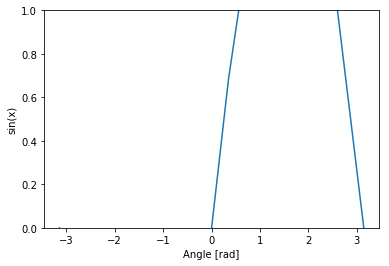

In [32]:
import matplotlib.pylab as plt
x = np.linspace(-np.pi, np.pi, 10)
y = np.sin((x))*2
print(y)
plt.plot(x,y )
plt.xlabel('Angle [rad]')
plt.ylabel('sin(x)')
plt.axis('tight')
plt.ylim((0,1))
plt.show()

In [1]:
from regain.datasets import make_ell

In [144]:
def generate_dataset_sin_cos(n_dim_obs=100, n_dim_lat=10, T=10, sparsity=0.95):
    L, K_OH = make_ell(n_dim_obs, n_dim_lat=n_dim_lat)
    
    phase = np.random.randn(n_dim_obs, n_dim_obs)*np.pi
    phase[np.triu_indices(n_dim_obs)[::-1]] = phase[np.triu_indices(n_dim_obs)]

    clip = np.zeros((n_dim_obs, n_dim_obs))
    picks = np.random.permutation(len(np.triu_indices(n_dim_obs,1)[0]))
    dim = int(len(np.triu_indices(n_dim_obs,1)[0])*sparsity)
    picks = picks[:dim]
    clip1 = clip[np.triu_indices(n_dim_obs,1)].ravel()
    clip1[picks] = 1
    clip[np.triu_indices(n_dim_obs,1)[::-1]] = clip[np.triu_indices(n_dim_obs,1)] = clip1
    
   
    thetas = np.array([np.eye(n_dim_obs) for i in range(T)])
    
    x = np.linspace(-np.pi, np.pi, T)
    plt.plot(x, np.sin((x+phase[1,2])/T**2)*(0.5/T))
    plt.show()
    for i in range(T):
        for r in range(thetas[i].shape[0]):
            for c in range(thetas[i].shape[1]):
                if r==c:
                    continue
                if clip[r,c]:
                    thetas[i,r,c] = np.sin((x[i]+phase[r,c])/T**2)*(0.5/T)
                else:
                    thetas[i,r,c] = np.sin((x[i]+phase[r,c]))*(0.5/T)
        thetas[i][clip==1] = np.clip(thetas[i][clip==1],0,1)
        thetas[i][np.abs(thetas[i])<1e-2]=0
        
        assert(is_pos_def(thetas[i]))
        theta_observed = thetas[i] - L
        assert(is_pos_def(theta_observed))
        thetas_obs = [theta_observed]

    return thetas, thetas_obs, L

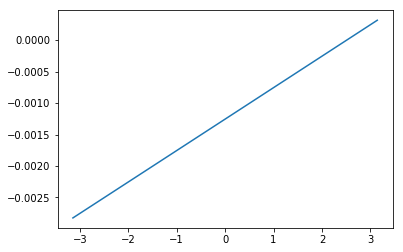

In [150]:
K, K_obs, L = generate_dataset_sin_cos(n_dim_obs=100, n_dim_lat=2,sparsity=0.99)

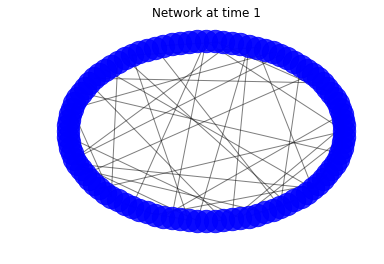

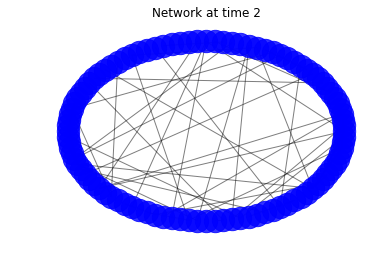

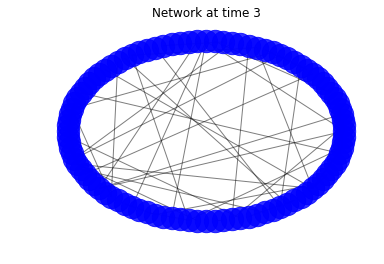

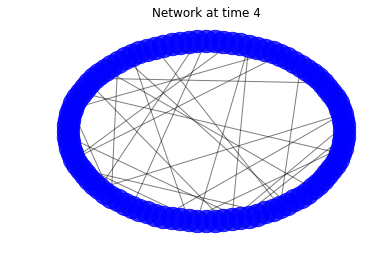

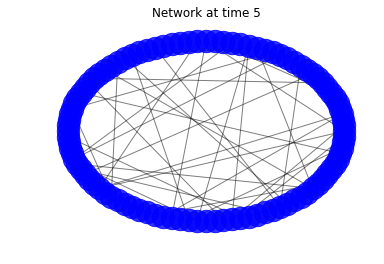

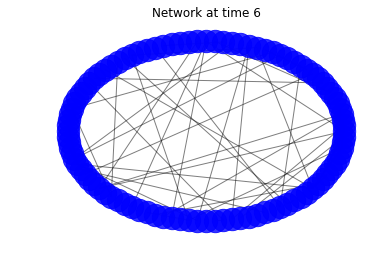

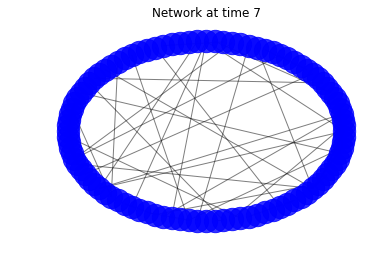

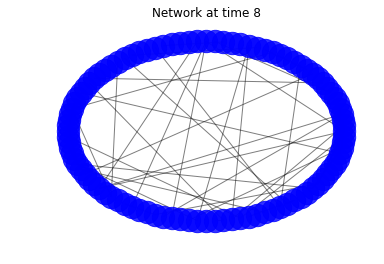

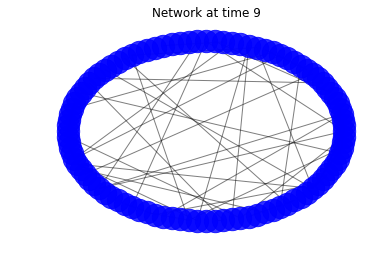

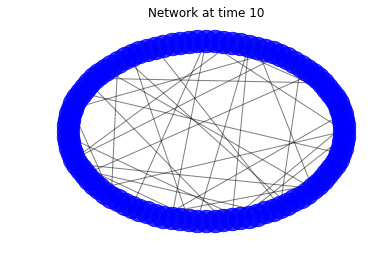

In [151]:
reload(plot)
for i, theta in enumerate(K):
   # theta[np.abs(theta)<1e-2] = 0
    plot.plot_graph_with_latent_variables(theta, 0, 100, "Network at time "+str(i+1))

In [5]:
thetas

array([[[ 1.        ,  0.        , -0.13439749, -0.28851397, -0.62703231],
        [ 0.        ,  1.        , -0.28232013,  0.        ,  0.        ],
        [-0.13439749, -0.28232013,  1.        , -0.63501557, -0.29280758],
        [-0.28851397,  0.        , -0.63501557,  1.        ,  0.18593737],
        [-0.62703231,  0.        , -0.29280758,  0.18593737,  1.        ]],

       [[ 1.        ,  0.        , -0.13439749, -0.28851397, -0.62703231],
        [ 0.        ,  1.        , -0.28232013,  0.        ,  0.        ],
        [-0.13439749, -0.28232013,  1.01006674, -0.79748313, -0.30648789],
        [-0.28851397,  0.        , -0.79748313,  1.04376563,  0.12154137],
        [-0.62703231,  0.        , -0.30648789,  0.12154137,  1.25289261]],

       [[ 1.        ,  0.        , -0.13439749, -0.28851397, -0.62703231],
        [ 0.        ,  1.        , -0.28232013,  0.        ,  0.        ],
        [-0.13439749, -0.28232013,  1.21718697, -0.75485224, -0.30405679],
        [-0.28851397,

In [6]:
from regain import utils; reload(utils)
from regain import prox; reload(prox)

<module 'regain.prox' from '/home/fede/src/slipguru/regain/regain/prox.pyc'>

In [152]:
from regain.admm import time_graph_lasso_; reload(time_graph_lasso_)
# from regain import latent_time_graph_lasso_admm; reload(latent_time_graph_lasso_admm)
Theta, S = time_graph_lasso_.time_graph_lasso(data_list, lamda=5, verbose=1, psi='l1')
# Theta, L, S = latent_time_graph_lasso_admm.time_latent_graph_lasso(data_list, alpha=5, verbose=1)

NameError: name 'data_list' is not defined

In [8]:
from sklearn.utils.extmath import squared_norm
np.sqrt(np.sum(squared_norm(t2 - t1[2:, 2:]) for t1, t2 in zip(thetas, Theta)))

4.6725848608604226

In [34]:
from regain.forward_backward import time_graph_lasso_ as tglf; reload(tglf)
from regain import utils; reload(utils)
from regain import prox; reload(prox)
TT, SS = tglf.time_graph_lasso(data_list, lamda=5, verbose=1, max_iter=4)

obj: inf, rnorm: 50460.3457, snorm: 20.0000,eps_pri: 30.0000, eps_dual: 30.0000


/home/fede/src/slipguru/regain/regain/forward_backward/time_graph_lasso_.py:41: RuntimeWarning: invalid value encountered in double_scalars
  obj_diff = partial_f(K=partial_J(alpha=alpha)) - partial_f(K=x)


obj: inf, rnorm: 1598.5893, snorm: 20.0000,eps_pri: 30.0000, eps_dual: 30.0000
obj: inf, rnorm: 1592.9820, snorm: 20.0000,eps_pri: 30.0000, eps_dual: 30.0000
obj: inf, rnorm: 1592.8615, snorm: 20.0000,eps_pri: 30.0000, eps_dual: 30.0000


/home/fede/src/slipguru/regain/regain/forward_backward/time_graph_lasso_.py:161: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


In [53]:
TT

array([[[ -646.58944249,  -988.39117577, -1553.99434288],
        [ -988.39117577,  -133.08129775,  -655.55779102],
        [-1553.99434288,  -655.55779102,  -293.10632723]],

       [[  -24.01004227,    25.97048436,    33.76397601],
        [   25.97048436,   -26.07832443,   -28.46257643],
        [   33.76397601,   -28.46257643,   -20.77389775]],

       [[  -19.2304697 ,    17.87486548,    31.14939787],
        [   17.87486548,   -26.07832443,    -1.56594634],
        [   31.14939787,    -1.56594634,   -20.77389775]],

       [[  -36.94849695,    57.63094751,    28.56784188],
        [   57.63094751,   -26.07832443,    -3.05463934],
        [   28.56784188,    -3.05463934,   -20.40706217]],

       [[  -19.18274575,    31.75652684,    28.56784188],
        [   31.75652684,   -25.1691955 ,   -18.7345842 ],
        [   28.56784188,   -18.7345842 ,   -20.40706217]],

       [[  -20.03581761,    28.9392754 ,     0.        ],
        [   28.9392754 ,   -26.4320108 ,     0.        ],
    

In [54]:
Theta

array([[[ 0.30925729, -0.21218965, -0.28647396],
        [-0.21218965,  0.94133665, -0.24383594],
        [-0.28647396, -0.24383594,  0.63524192]],

       [[ 1.35307129,  0.18879498,  0.3566438 ],
        [ 0.18879498,  1.24989632, -0.2018844 ],
        [ 0.3566438 , -0.2018844 ,  1.53681131]],

       [[ 1.65658332,  0.10807513,  0.34458553],
        [ 0.10807513,  1.0639398 ,  0.04665617],
        [ 0.34458553,  0.04665617,  1.40961378]],

       [[ 1.08742069,  0.45562093,  0.18729992],
        [ 0.45562093,  1.30223546,  0.03510654],
        [ 0.18729992,  0.03510654,  1.30459743]],

       [[ 1.73689178,  0.34804705,  0.38306464],
        [ 0.34804705,  1.34801302, -0.04855219],
        [ 0.38306464, -0.04855219,  1.50108411]],

       [[ 1.51655306,  0.206467  ,  0.01257692],
        [ 0.206467  ,  1.20258565, -0.01653621],
        [ 0.01257692, -0.01653621,  1.93030758]],

       [[ 1.54258123,  0.20577771,  0.2078426 ],
        [ 0.20577771,  1.50880119,  0.01263753],
        

In [33]:
thetas

array([[[ 1.        , -0.34453602, -0.66030379, -0.18167471, -0.35513243],
        [-0.34453602,  1.        , -0.22801522, -0.14657172, -0.19736042],
        [-0.66030379, -0.22801522,  1.        ,  0.        ,  0.        ],
        [-0.18167471, -0.14657172,  0.        ,  1.        , -0.15269502],
        [-0.35513243, -0.19736042,  0.        , -0.15269502,  1.        ]],

       [[ 1.        , -0.52195535, -1.        , -0.27533273, -0.53825901],
        [-0.52195535,  1.        , -0.34498077, -0.22230154, -0.29882665],
        [-1.        , -0.34498077,  1.        ,  0.        ,  0.        ],
        [-0.27533273, -0.22230154,  0.        ,  1.        , -0.23153829],
        [-0.53825901, -0.29882665,  0.        , -0.23153829,  1.        ]],

       [[ 1.        , -0.52243346, -1.        , -0.27513566, -0.53816743],
        [-0.52243346,  1.        , -0.34510999, -0.22256228, -0.29877581],
        [-1.        , -0.34510999,  1.        ,  0.        ,  0.        ],
        [-0.27513566,

[[ 1.          0.         -0.64750096]
 [ 0.          1.          0.        ]
 [-0.64750096  0.          1.        ]]
[[ 1.4635202   0.01791391 -0.02064731]
 [ 0.01791391  1.23771168 -0.01574106]
 [-0.02064731 -0.01574106  1.27659373]]


NetworkXError: Node 3 has no position.

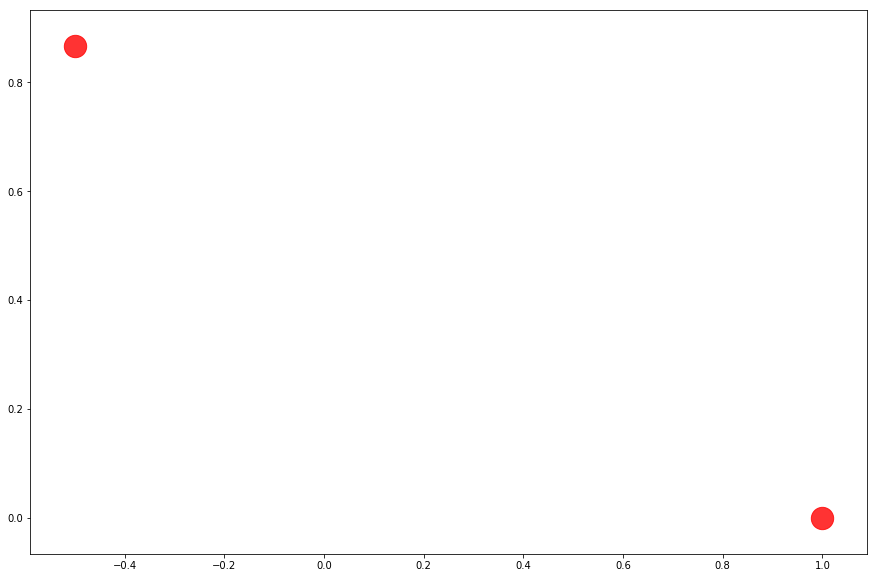

In [46]:
for i, (theta_true, theta_inferred) in enumerate(zip(thetas, Theta)):
    print(theta_true[2:, 2:])
    print(theta_inferred)
    plot_graph_with_latent_variables(theta_true[2:, 2:], 2,3, "Network at time "+str(i+1)+ " true")
    plot_graph_with_latent_variables(theta_inferred, 2,3, "Network at time "+str(i+1)+ " inferred")

In [11]:
import sys
sys.path.insert(0, "/home/fede/src/TVGL/")

import TVGL; reload(TVGL)
thetaSet, empCovSet, status = TVGL.tvgl_hallac(data_list, lamb=5, beta=1, indexOfPenalty=3,
                                               verbose=1, max_iter=250)

Use laplacian penalty function
Distributed ADMM (16 processors)
obj: 247.8907, rnorm: 0.8714, snorm: 8.6547,eps_pri: 0.0182, eps_dual: 0.0229
obj: 307.9248, rnorm: 1.1533, snorm: 3.4327,eps_pri: 0.0203, eps_dual: 0.0244
obj: 329.4759, rnorm: 1.1490, snorm: 1.5596,eps_pri: 0.0212, eps_dual: 0.0258
obj: 330.3288, rnorm: 1.0382, snorm: 0.6931,eps_pri: 0.0215, eps_dual: 0.0270
obj: 322.2870, rnorm: 0.9015, snorm: 0.3897,eps_pri: 0.0215, eps_dual: 0.0280
obj: 312.0915, rnorm: 0.7740, snorm: 0.3618,eps_pri: 0.0214, eps_dual: 0.0288
obj: 302.4083, rnorm: 0.6672, snorm: 0.3540,eps_pri: 0.0212, eps_dual: 0.0294
obj: 293.9207, rnorm: 0.5822, snorm: 0.3204,eps_pri: 0.0211, eps_dual: 0.0300
obj: 287.1453, rnorm: 0.5160, snorm: 0.2745,eps_pri: 0.0210, eps_dual: 0.0304
obj: 281.7798, rnorm: 0.4648, snorm: 0.2286,eps_pri: 0.0209, eps_dual: 0.0308
obj: 277.5033, rnorm: 0.4247, snorm: 0.1883,eps_pri: 0.0208, eps_dual: 0.0312
obj: 274.0531, rnorm: 0.3926, snorm: 0.1552,eps_pri: 0.0207, eps_dual: 0.0315


obj: 245.6455, rnorm: 0.0285, snorm: 0.0107,eps_pri: 0.0202, eps_dual: 0.0382
obj: 245.6345, rnorm: 0.0275, snorm: 0.0050,eps_pri: 0.0202, eps_dual: 0.0382
obj: 245.6238, rnorm: 0.0237, snorm: 0.0069,eps_pri: 0.0202, eps_dual: 0.0382
obj: 245.6135, rnorm: 0.0217, snorm: 0.0081,eps_pri: 0.0202, eps_dual: 0.0382
obj: 245.6035, rnorm: 0.0209, snorm: 0.0020,eps_pri: 0.0202, eps_dual: 0.0382
obj: 245.5943, rnorm: 0.0203, snorm: 0.0016,eps_pri: 0.0202, eps_dual: 0.0382
obj: 245.5856, rnorm: 0.0197, snorm: 0.0016,eps_pri: 0.0202, eps_dual: 0.0382


In [26]:
theta_true

array([[ 1.        , -0.02406126,  0.        , -0.31275297, -0.24028736],
       [-0.02406126,  1.        , -0.36633203,  0.11670707,  0.18709591],
       [ 0.        , -0.36633203,  1.        ,  0.        ,  0.        ],
       [-0.31275297,  0.11670707,  0.        ,  1.        ,  0.        ],
       [-0.24028736,  0.18709591,  0.        ,  0.        ,  1.        ]])

In [30]:
from sklearn.utils.extmath import squared_norm
np.sqrt(np.sum(squared_norm(t2 - t1) for t1, t2 in zip(thetas, thetaSet)))

9.037527378090882